In [1]:
import numpy as np
import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = (20,4)

%load_ext autoreload
%autoreload 2

# DESIGN KALMAN FILTER

In [2]:
beacons = np.array(['Beacon00001', 'Beacon00002', 'Beacon00003', 'Beacon00004', 'Beacon00005', 'Beacon00006'])


ch_4min: mean -68.67544081923077 	 var 0.7570427803950981
all_ch_20s: mean -68.16666666666667 	 var 5.1388888888888875


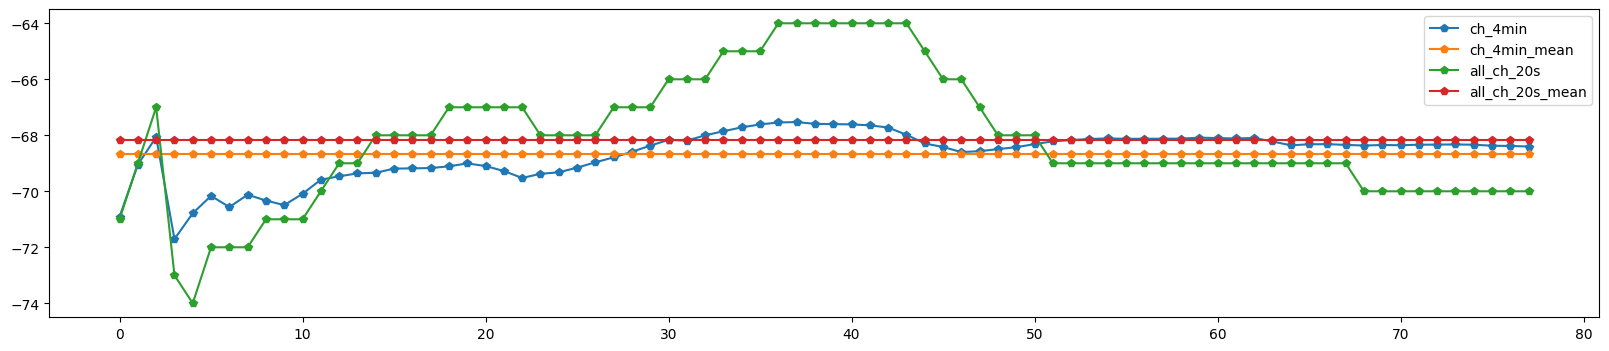

In [46]:
ch_4min = np.array([-70.9090919 , -69.04760875, -68.0644913 , -71.7074337 ,
    -70.78434948, -70.16390528, -70.56340883, -70.1234027 ,
    -70.32967006, -70.49509742, -70.08998918, -69.5864683 ,
    -69.46530232, -69.36131846, -69.33737367, -69.19208121,
    -69.18083838, -69.17083729, -69.10946814, -69.00438855,
    -69.09909779, -69.27587726, -69.52408718, -69.37759388,
    -69.32260125, -69.15662978, -68.96590812, -68.78874505,
    -68.58928652, -68.36974521, -68.16430185, -68.19042128,
    -68.00274762, -67.85549604, -67.71661924, -67.61323737,
    -67.54248978, -67.52818506, -67.59171241, -67.60194664,
    -67.61168413, -67.64484847, -67.72315899, -67.98046927,
    -68.29335878, -68.41799445, -68.60150541, -68.56796165,
    -68.49472911, -68.42440875, -68.31736053, -68.2144045 ,
    -68.17232175, -68.13178775, -68.11104531, -68.12705267,
    -68.12480408, -68.12263249, -68.120534  , -68.08483732,
    -68.09999681, -68.11467096, -68.09677752, -68.22171746,
    -68.35841638, -68.32223046, -68.31735796, -68.34243877,
    -68.36679897, -68.34698959, -68.35632498, -68.33719516,
    -68.33250218, -68.32793479, -68.337048  , -68.37270045,
    -68.38099409, -68.40213571])
all_ch_20s = np.array([-71,-69,-67,-73,-74,-72,-72,-72,-71,-71,-71,-70,-69,-69,-68,-68,-68,-68,-67,-67,-67,-67,-67,-68,-68,-68,-68,-67,-67,-67,-66,-66,-66,-65,-65,-65,-64,-64,-64,-64,-64,-64,-64,-64,-65,-66,-66,-67,-68,-68,-68,-69,-69,-69,-69,-69,-69,-69,-69,-69,-69,-69,-69,-69,-69,-69,-69,-69,-70,-70,-70,-70,-70,-70,-70,-70,-70,-70])
plt.plot(list(range(ch_4min.size)), ch_4min, 'p-')
plt.plot(list(range(ch_4min.size)), np.full(ch_4min.size,ch_4min.mean()), 'p-')
plt.plot(list(range(all_ch_20s.size)), all_ch_20s, 'p-')
plt.plot(list(range(all_ch_20s.size)), np.full(all_ch_20s.size,all_ch_20s.mean()), 'p-')

plt.legend([
    'ch_4min',
    'ch_4min_mean',
    'all_ch_20s',
    'all_ch_20s_mean'
])

print(f'ch_4min: mean {ch_4min.mean()} \t var {ch_4min.var()}')
print(f'all_ch_20s: mean {all_ch_20s.mean()} \t var {all_ch_20s.var()}')


In [27]:
from filterpy.kalman import KalmanFilter
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise

def tracker2D(R=100, P=400, Q=0.01):
    tracker = KalmanFilter(dim_x=2, dim_z=1)
    dt = 1  # time step

    tracker.F = np.array([
                    [1, dt],
                    [0,  1],
                ])
    tracker.u = 0.
    tracker.H = np.array([[1, 0]])
    tracker.R = np.eye(1) * R
    tracker.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)
    tracker.x = np.array([[-60,0.5]]).T
    tracker.P = np.eye(2) *P
    return tracker


In [43]:
tracker = tracker2D()
# tracker2 = tracker2D()
# tracker2 = tracker2D(R=5, P=10)
beacon_idx = 4
rssi_measured_beacon1 = np.array([-75, -70, -66, -71, -67, -65, -69, -65, -66, -65, -68, -65, -65, -65, -64, -64, -70, -65, -67, -65, -65, -66, -66, -65, -64, -67, -74, -71, -62, -68, -68, -64, -62, -66, -66, -65, -62, -67, -66, -60, -62, -65, -68, -64, -64, -68, -67, -68, -63, -68, -66, -67, -73, -65, -72, -71, -71, -64, -73, -71, -75, -64, -71, -71, -63, -78, -65, -65, -73, -75, -66, -68, -68, -64, -74, -70, -62, -74, -76, -68, -64, -71, -72, -72, -64, -72, -62])
# rssi_measured_beacon1 = np.array([-68,-66,-61,-61,-61,-61,-61,-62,-62,-69,-69,-68,-67,-68,-67,-67,-68,-70,-70,-68,-70,-70,-69,-69,-69,-69,-69,-71,-70,-69,-64,-64,-64,-64,-64,-64,-64,-64,-64,-65,-67,-65,-64,-64,-64,-64,-64,-64,-64,-63,-63,-65,-63,-64,-64,-64,-64,-64,-64,-64,-66,-64,-64,-64,-64,-64,-64,-64,-64,-64,-64,-64,-63,-64,-64,-63,-64,-63,-65,-64,-67,-66,-65,-65,-65,-65,-68,-66,-64,-64,-63,-64,-64,-65,-65,-66,-67,-67,-67,-62,-63,-62,-62,-63,-63,-62,-61,-62,-61,-62,-62,-61,-62,-61,-62,-61,-63,-62,-62,-62,-62,-64,-61,-64,-61,-62,-63,-63,-62,-61,-60,-60,-60,-60,-60,-62,-64,-62,-63,-63,-62,-62,-62,-61,-64,-66,-64,-66,-63,-64,-62,-65])
# rssi_measured_beacon1 = rssi_measured_beacon1[0::3]
rssi_measured_beacon1 = ch_4min
xs = np.array(range(rssi_measured_beacon1.size))
ys = rssi_measured_beacon1

# tracker = KalmanFilter(dim_x=1, dim_z=1)
# tracker.x = np.array([[-60]])
# tracker.P *= 1000
# tracker.R *= 100
# tracker.Q = np.array([[0.001]])
# tracker.H=np.array([[1]])
# print(tracker)
filter_xs, ps_rssi = [], []
for idx,rssi in enumerate(rssi_measured_beacon1):
    print('times: ', idx)
    print('height measurement: ', rssi)
    tracker.predict()
    tracker.update(rssi)
    
    # # batch 
    # tracker2.predict()
    # tracker2.update(tracker.x[0][0])

    # rssi_kalman_beacon1 = np.append(rssi_kalman_beacon1, int(tracker.x[0][0]))
    print('===================')
    # collect data to estimate model
    filter_xs.append(tracker.x)
    ps_rssi.append(tracker.P.diagonal()) # just save variances
    
filter_xs = np.asarray(filter_xs)
ps_rssi = np.asarray(ps_rssi)
# rssi_kalman_beacon1 = rssi_kalman_beacon1.reshape(len(rssi_kalman_beacon1),1)

KalmanFilter object
dim_x = 1
dim_z = 1
dim_u = 0
x = [[-60]]
P = [[1000.]]
x_prior = [[0.]]
P_prior = [[1.]]
x_post = [[0.]]
P_post = [[1.]]
F = [[1.]]
Q = [[0.001]]
R = [[100.]]
H = [[1]]
K = [[0.]]
y = [[0.]]
S = [[0.]]
SI = [[0.]]
M = [[0.]]
B = None
z = [[None]]
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
alpha = 1.0
inv = <function inv at 0x0000028E13A55040>
times:  0
height measurement:  -72
times:  1
height measurement:  -67
times:  2
height measurement:  -66
times:  3
height measurement:  -83
times:  4
height measurement:  -67
times:  5
height measurement:  -67
times:  6
height measurement:  -73
times:  7
height measurement:  -67
times:  8
height measurement:  -72
times:  9
height measurement:  -72
times:  10
height measurement:  -66
times:  11
height measurement:  -64
times:  12
height measurement:  -68
times:  13
height measurement:  -68
times:  14
height measurement:  -69
times:  15
height measurement:  -67
times:  16
height me

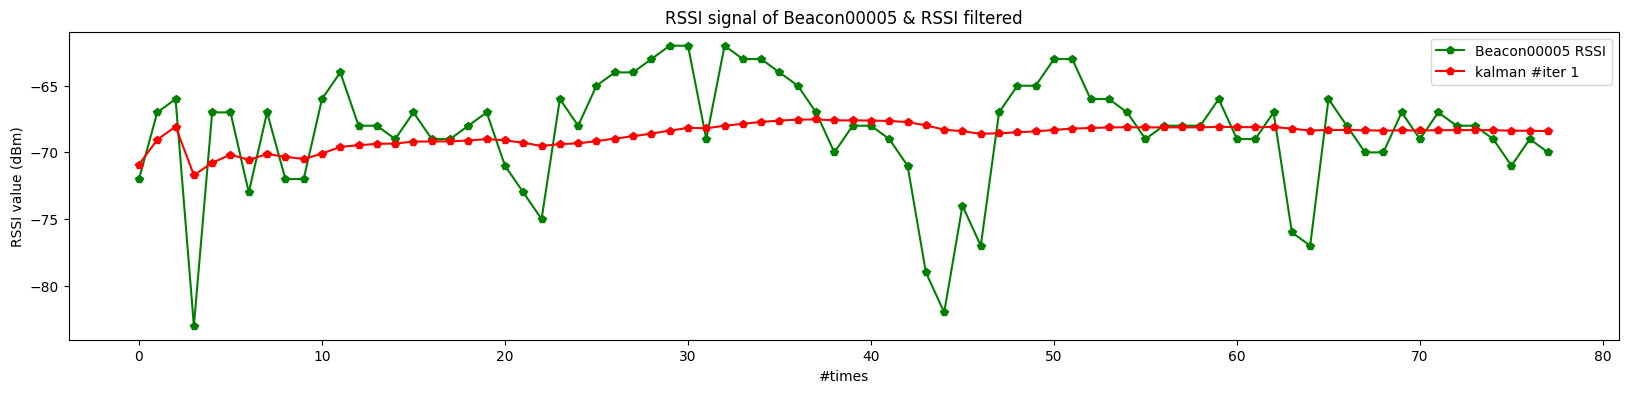

In [44]:
plt.plot(xs,ys, 'pg-')

plt.plot(xs,filter_xs[:,0].reshape(1,-1)[0],'pr-')

# plt.plot(xs,filter_xs[:,0].reshape(1,-1)[0],'p-')
# plt.plot(xs,filter_xs[:,0].reshape(1,-1)[0],'+')

plt.title(f'RSSI signal of {beacons[beacon_idx]} & RSSI filtered')
plt.xlabel('#times')
plt.ylabel('RSSI value (dBm)')
plt.legend(np.append(beacons[beacon_idx] + ' RSSI',['kalman #iter 1','kalman #iter 2']))
plt.savefig('./img/RSSI_kalmanFilter')
plt.show()

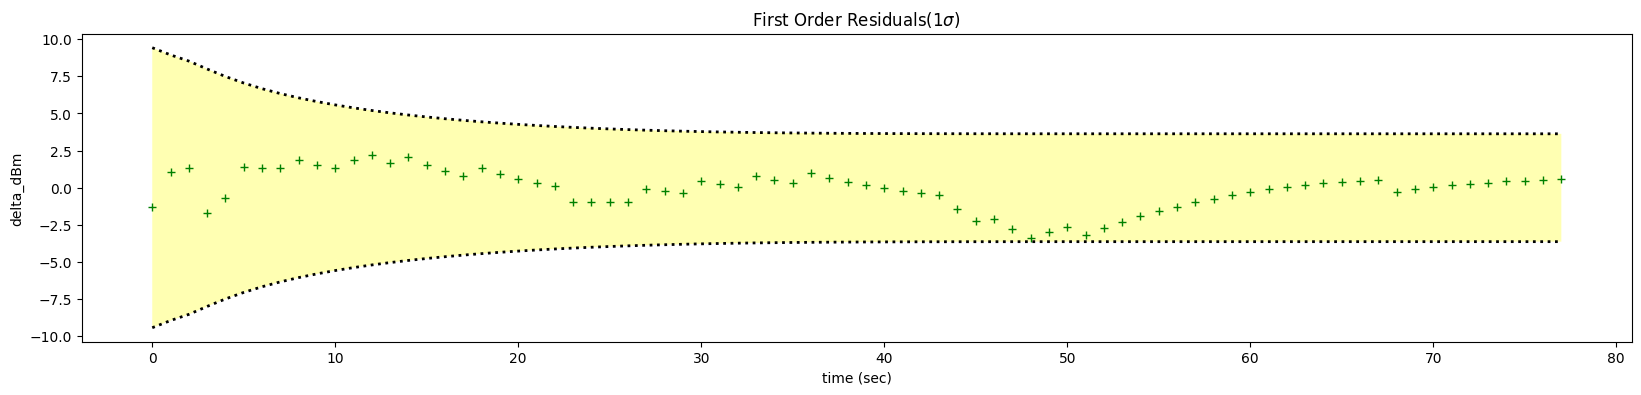

% valid predicted values: 100.0%
>good fit filter model: std = 4.336931554394001


In [31]:
import book_plots as bp

bp.plot_residuals(xs=ys, filter_xs=filter_xs[:,0].reshape(1,-1)[0],
                Ps=ps_rssi[:,0],
                stds=1,
                title='First Order Residuals(1$\sigma$)',
                y_label='delta_dBm')

# bp.plot_residuals(xs=ys, filter_xs=rssi_kalman_beacon1[:,0],
#                 Ps=rssi_kalman_beacon1[:,1],
#                 stds=1,
#                 title='First Order Residuals(1$\sigma$)',
#                 y_label='delta_dBm')

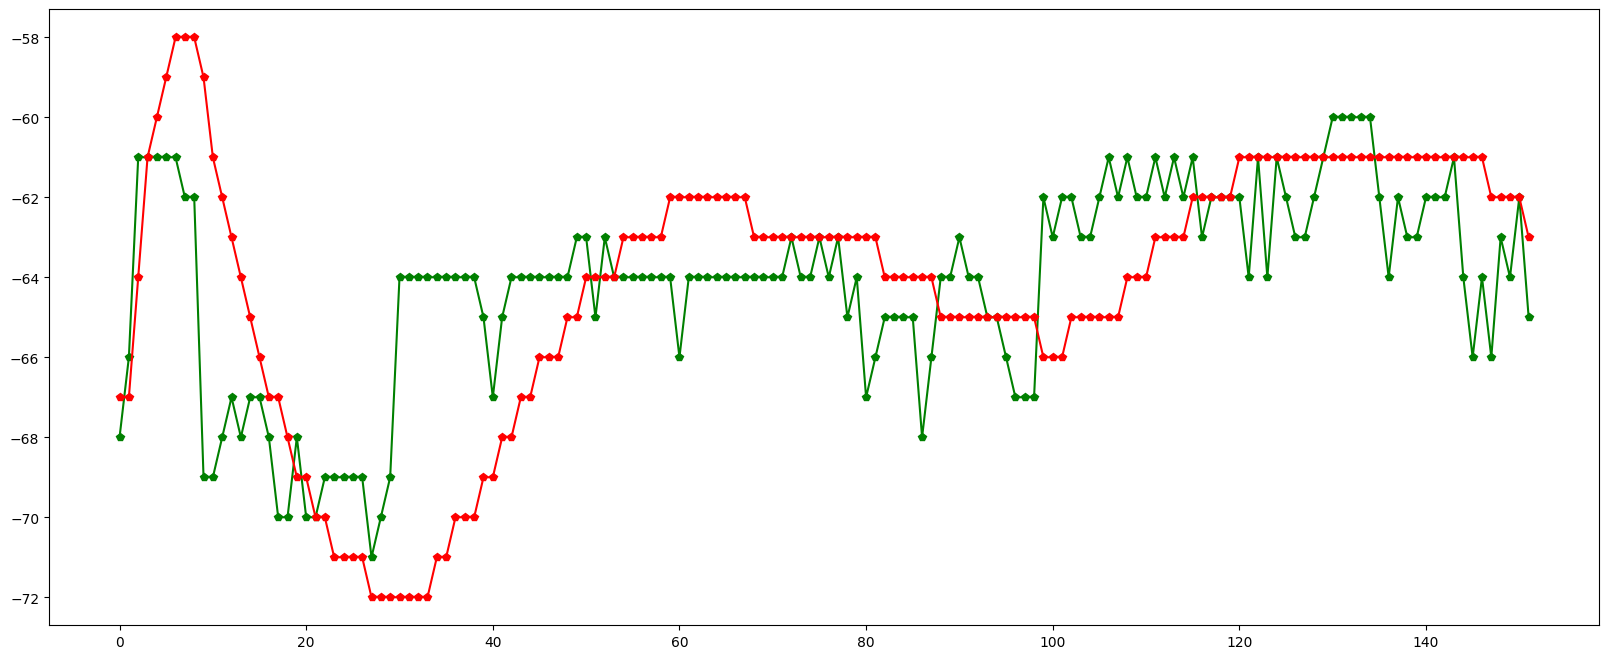

In [28]:

raw_rssi = np.array([-68,-66,-61,-61,-61,-61,-61,-62,-62,-69,-69,-68,-67,-68,-67,-67,-68,-70,-70,-68,-70,-70,-69,-69,-69,-69,-69,-71,-70,-69,-64,-64,-64,-64,-64,-64,-64,-64,-64,-65,-67,-65,-64,-64,-64,-64,-64,-64,-64,-63,-63,-65,-63,-64,-64,-64,-64,-64,-64,-64,-66,-64,-64,-64,-64,-64,-64,-64,-64,-64,-64,-64,-63,-64,-64,-63,-64,-63,-65,-64,-67,-66,-65,-65,-65,-65,-68,-66,-64,-64,-63,-64,-64,-65,-65,-66,-67,-67,-67,-62,-63,-62,-62,-63,-63,-62,-61,-62,-61,-62,-62,-61,-62,-61,-62,-61,-63,-62,-62,-62,-62,-64,-61,-64,-61,-62,-63,-63,-62,-61,-60,-60,-60,-60,-60,-62,-64,-62,-63,-63,-62,-62,-62,-61,-64,-66,-64,-66,-63,-64,-62,-65])
filtered_rssi = np.array([-67,-67,-64,-61,-60,-59,-58,-58,-58,-59,-61,-62,-63,-64,-65,-66,-67,-67,-68,-69,-69,-70,-70,-71,-71,-71,-71,-72,-72,-72,-72,-72,-72,-72,-71,-71,-70,-70,-70,-69,-69,-68,-68,-67,-67,-66,-66,-66,-65,-65,-64,-64,-64,-64,-63,-63,-63,-63,-63,-62,-62,-62,-62,-62,-62,-62,-62,-62,-63,-63,-63,-63,-63,-63,-63,-63,-63,-63,-63,-63,-63,-63,-64,-64,-64,-64,-64,-64,-65,-65,-65,-65,-65,-65,-65,-65,-65,-65,-65,-66,-66,-66,-65,-65,-65,-65,-65,-65,-64,-64,-64,-63,-63,-63,-63,-62,-62,-62,-62,-62,-61,-61,-61,-61,-61,-61,-61,-61,-61,-61,-61,-61,-61,-61,-61,-61,-61,-61,-61,-61,-61,-61,-61,-61,-61,-61,-61,-62,-62,-62,-62,-63])
xs = np.array(range(raw_rssi.size))
plt.plot(xs,raw_rssi, 'pg-')
plt.plot(xs,filtered_rssi, 'pr-')
